<a href="https://colab.research.google.com/github/leticiaram/Modelacion-Epidemiologica/blob/main/9_EON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

EoN es un módulo de Python que permite realizar simuaciones de modelos compartmentales SIS y SIR estocásticos en redes con algoritmos como Gillespie y simulaciones basadas en eventos (event-based simulations) y en tiempo discreto o continuo.


In [ ]:
!pip install EoN

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for EoN: filename=EoN-1.2-py3-none-any.whl size=122467 sha256=2f0df64674e7cf7019ce695526f1c3a5b9cb4fa2f4194c78b4120374a8966ca0
  Stored in directory: /root/.cache/pip/wheels/5c/f5/1a/a0eb87d5be57c62526fbd133651c442482ea5a997d88382007
Successfully built EoN


In [ ]:
import EoN

import networkx as nx
from matplotlib import rc
import matplotlib.pylab as plt

#import scipy
#import random
import numpy as np

import collections
import scipy.stats as stats

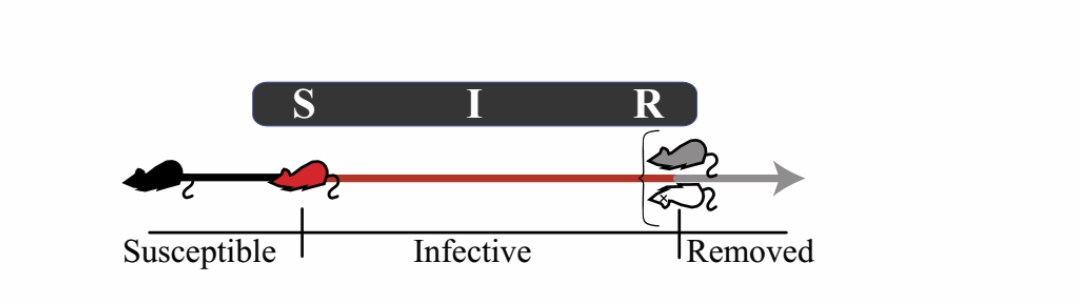

## Ejemplo 1: SIR en red Barabasi-Albert

Creamos una red aleatoria (Barabasi-Albert en este ejemplo) con N vertices

In [ ]:
N = 10**5   #cien mil nodos
G = nx.barabasi_albert_graph(N, 2)  # Red aleatoria Barabasi-Albert

786


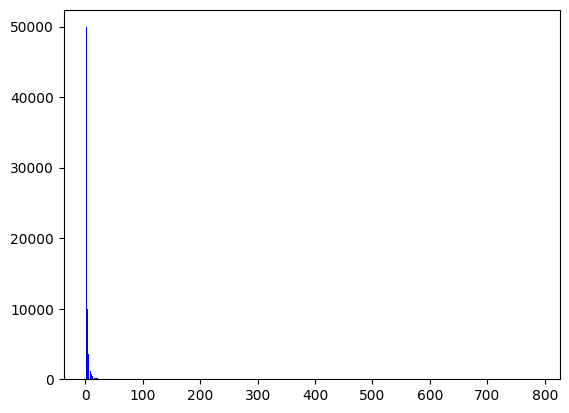

In [ ]:
degree_sequence = sorted([d for n,d in G.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
plt.bar(deg, cnt, width=0.80, color='b')
print(max(deg))

In [ ]:
np.max(list(dict(G.degree).values()))

786

In [ ]:
grados = list(dict(G.degree).values())
EK = np.mean(grados)
EK

3.99992

In [ ]:
grados2 = resultado = [x ** 2 for x in grados]
EK2 = np.mean(grados2)
EK2

71.92274

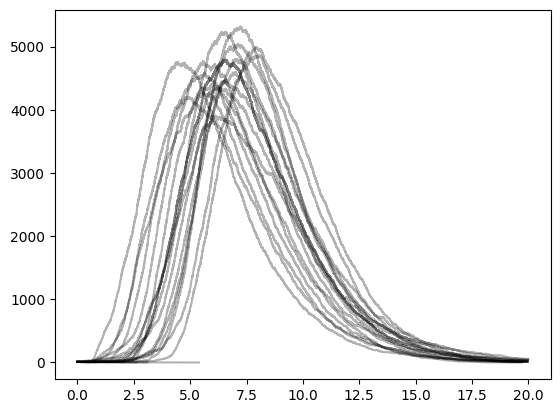

In [ ]:
tmax = 20
iterations = 20   # corre 20 simulaciones
tau = 0.3        # tasa de transmisión
gamma = 1.0      # tasa de recuperación
rho = 0.0001      # fracción aleatoria de casos infectados iniciales

for i in range(iterations): # corre la simulaciones
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
    if i == 0:
        plt.plot(t, I, color = 'k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color = 'k', alpha=0.3)

### $R_0$ y $\cal{R}$

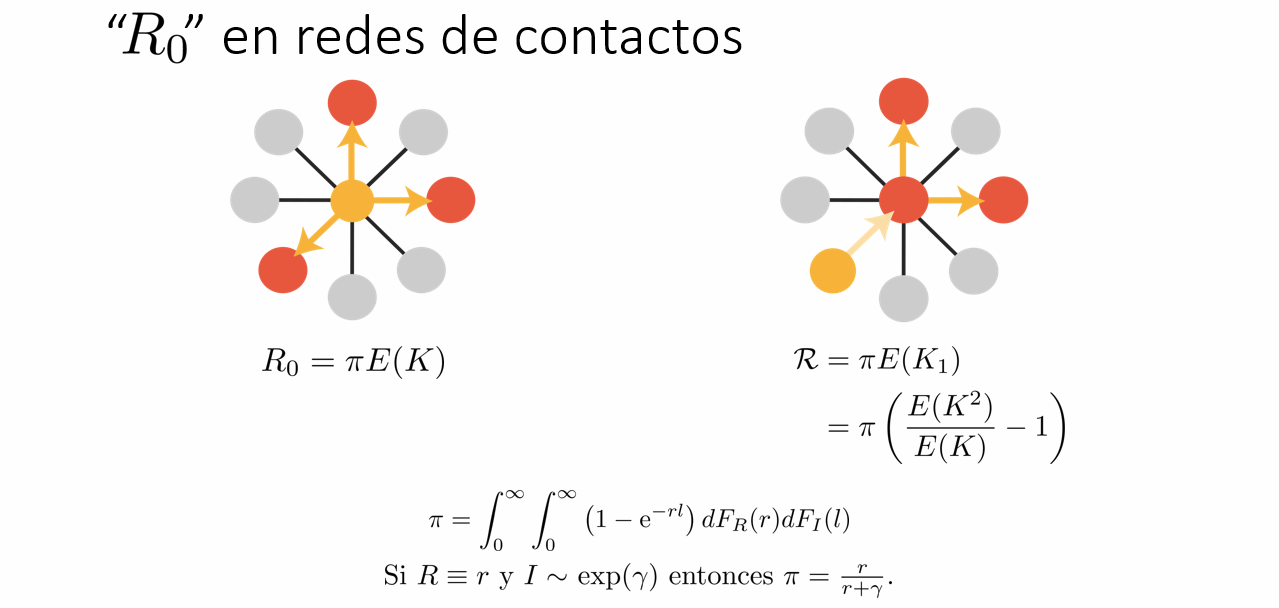

In [ ]:
R0 = tau /(tau +gamma)*EK
R0

0.9230584615384615

In [ ]:
R = tau /(tau +gamma)*(EK2/EK-1)
R

3.9187026048213274

## Ejemplo 2: SIR en tres redes

Construimos tres diferenes redes usando el modelo de configuración. Poisson, Regular y Power Law truncado. Usamos el modelo de configuración.

59936
60000
58036


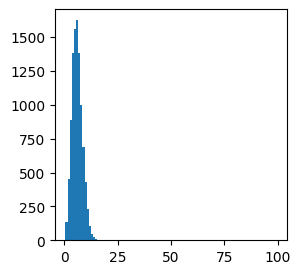

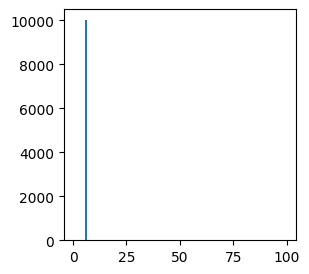

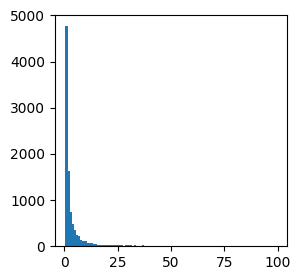

In [ ]:
N = 10000      # nodos
target_k = 6  # parametro para la red regular

# Red Poisson
np.random.seed(23)
k_pois = np.random.poisson(target_k, N)
print(sum(k_pois.tolist()))
G_Poisson = nx.configuration_model(k_pois.tolist())

# Red Regular (todos tienen el mismo grado)
k_reg = [target_k]*N
print(sum(k_reg))
G_Reg = nx.configuration_model(k_reg)

# Red Power Law (Ley de potencias) trucada en 0
def truncated_power_law(a, m):
    x = np.arange(1, m+1, dtype='float')
    pmf = 1/x**a
    pmf /= pmf.sum()
    return stats.rv_discrete(values=(range(1, m+1), pmf))

a, m = 1.65, 100
d = truncated_power_law(a=a, m=m)
k_0PL = d.rvs(size=N)
print(sum(k_0PL))
G_0PL = nx.configuration_model(k_0PL)

plt.figure(figsize=(3, 3))
plt.hist(k_pois, bins=np.arange(m)+0.5)
plt.show()
plt.figure(figsize=(3, 3))
plt.hist(k_reg, bins=np.arange(m)+0.5)
plt.show()
plt.figure(figsize=(3, 3))
plt.hist(k_0PL, bins=np.arange(m)+0.5)
plt.show()

In [ ]:
print(np.mean(k_pois))
print(np.mean(k_reg))
print(np.mean(k_0PL))

5.9936
6.0
5.8036


In [ ]:
tau = 0.5       # tasa de transmisión
gamma = 1.      # tasa de recuperación
count = 50      # number of simulations to run for each
rho = 0.025     # fracción aleatoria de casos infectados iniciales.

colors = ['#5AB3E6','#FF2000','#009A80','#E69A00', '#CD9AB3', '#0073B3',
        '#F0E442']

def sir_sim(k, N, color, label, count):
    report_times = np.arange(0,30,0.1) #scipy.linspace(0,30,3000)
    sums = 0*report_times
    for cnt in range(count):
        G = nx.configuration_model(k)
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho)
        if cnt==0:
          plt.plot(t, I*1./N, '-', color = color,
                                alpha = 0.3, linewidth=1,label=label)
        else:
          plt.plot(t, I*1./N, '-', color = color,
                                alpha = 0.3, linewidth=1)

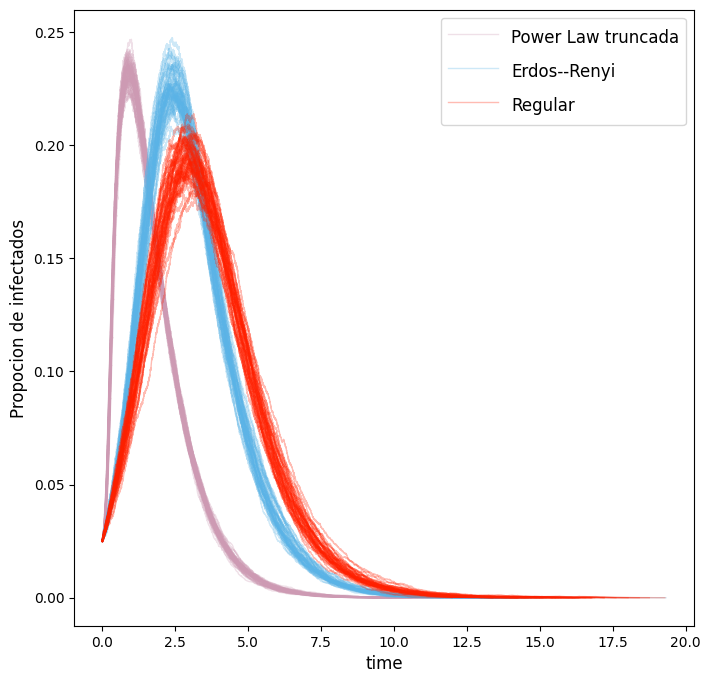

In [ ]:
plt.figure(figsize=(8,8))

#Powerlaw
sir_sim(k_0PL, N, colors[4], 'Power Law truncada', count)
#Poisson
sir_sim(k_pois, N, colors[0], 'Poisson', count)
#Homogeneous
sir_sim(k_reg, N, colors[1], 'Regular', count)

plt.xlabel('time', fontsize=12)
plt.ylabel('Propocion de infectados', fontsize=12)
plt.legend(loc = 'upper right', numpoints=1, fontsize=12, handlelength=3, handleheight=2)
plt.show()

## Ejemplo 3: Comparando el modelo 1 con modelo epidemiológico sin redes

**Modelo compartimental con acción de masas**

$\frac{dS}{dt}=-\tau SI/N$

$\frac{dI}{dt}=\tau SI/N-\gamma I$

$\frac{dR}{dt}=\gamma I$

In [ ]:
from scipy.integrate import odeint

def sir_ode(X,t,theta):
  ### Las siguientes matrices tt y XX se definen para tener el sistema de ode en forma matricial
  dS = -theta[0]*X[0]*X[1]/theta[2]
  dI = theta[0]*X[0]*X[1]/theta[2] - theta[1]*X[1]
  dR = theta[1]*X[1]
  sols = np.array([dS,dI,dR])
  sols = sols.reshape(3,)
  return(sols)

In [ ]:
N = 10**5   #cien mil nodos

tau = 0.3        # tasa de transmisión
gamma = 1.0      # tasa de recuperación
rho = 0.0001      # fracción aleatoria de casos infectados iniciales

S0 = N*(1-rho)
I0 = rho*N
R0 = 0.

print('tau = ',tau)
beta = (gamma*tau/(gamma+tau))*(EK2/EK-1)
#beta = gamma * R
print('beta = ',beta)

theta = [beta, gamma, N]
#estados inciales
X0 = [S0,I0,R0]
print(X0)
tiempo = np.arange(0, 20, 0.01)  ## vector de tiempos

solucion = odeint(sir_ode, X0, tiempo, args=(theta,))#, args=theta)  #No funciona con no matricial

tau =  0.3
beta =  3.9187026048213274
[99990.0, 10.0, 0.0]


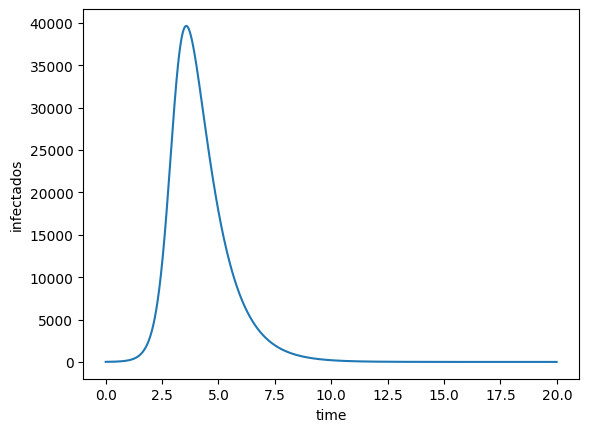

In [ ]:
plt.plot(tiempo,solucion[:,1]) #infectados
plt.xlabel('time')
plt.ylabel('infectados')
plt.show()

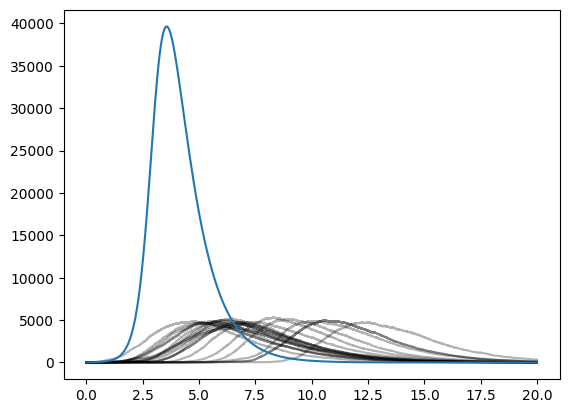

In [ ]:
tmax = 20
iterations = 20   # corre 20 simulaciones

for i in range(iterations): # corre la simulaciones
    t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax = tmax)
    if i == 0:
        plt.plot(t, I, color = 'k', alpha=0.3, label='Simulation')
    plt.plot(t, I, color = 'k', alpha=0.3)

plt.plot(tiempo,solucion[:,1]) #infectados